# Emotion Estimation - BERLIN Dataset

Ujjwal Gutta - 1215350903

In [ ]:
# Mounting the Google Drive to Colab Notebook
from google.colab import drive
drive.mount('/content/drive/')
!ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········


In [ ]:
# Installing the necessary Python packages
pip install librosa soundfile scikit-learn==0.22

     |████████████████████████████████| 7.0MB 4.1MB/s 
  Found existing installation: scikit-learn 0.21.3
    Uninstalling scikit-learn-0.21.3:
      Successfully uninstalled scikit-learn-0.21.3


# Feature Extraction

In [ ]:
# Emotions in the BERLIN dataset
emotions_B={
  '01':'Angry',
  '02':'Happy',
  '03':'Neutral',
  '04':'Sad'
}

# Emotions to be Observed
observed_emotions_B = list(emotions_B.values())

In [ ]:
# Extracting Speech features from sound files

import librosa
import soundfile
import numpy as np
import os, glob, pickle
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Extract features from a sound file
def extract_BERLIN_features(file_name, mfcc,energy,zcr,flat, contrast):
  with soundfile.SoundFile(file_name) as sound_file:
    X = sound_file.read(dtype="float32")
    sample_rate = sound_file.samplerate
    result = np.array([])
    if contrast:
        stft = np.abs(librosa.stft(X))
    if mfcc:
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
        result = np.hstack((result, mfccs))
    if energy:
        S, phase = librosa.magphase(librosa.stft(X))
        rms = np.mean(librosa.feature.rms(S=S).T, axis=0)
        result = np.hstack((result, rms))
    if zcr:
        z = np.mean(librosa.feature.zero_crossing_rate(X).T, axis = 0)    
        result = np.hstack((result, z))
    if flat:
        flatness = np.mean(librosa.feature.spectral_flatness(y=X).T, axis=0)
        result = np.hstack((result, flatness))    
    if contrast:
        spec_contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T, axis=0)
        result = np.hstack((result, spec_contrast))
    return result

# Loading the data and extracting features for each sound file
x,y = [],[]
files_loc = 'drive/My Drive/speech_trial/BERLIN/{0}/*.wav'
for obvEmotion in observed_emotions_B:
  for file in glob.glob(files_loc.format(obvEmotion)):
    file_name = os.path.basename(file)
    emotion = obvEmotion
    if emotion not in observed_emotions_B:
      continue
    feature = extract_BERLIN_features(file, mfcc=True, energy=True, zcr=True, flat=True, contrast=True)
    x.append(feature)
    y.append(emotion)

x_train, x_test, y_train, y_test= train_test_split(np.array(x), y, test_size=0.25, random_state=None)

# I. Deep Neural Network - MLP


Accuracy (MLP): 84.71%

Classification Report
              precision    recall  f1-score   support

       Angry       0.89      0.82      0.85        38
       Happy       0.72      0.76      0.74        17
     Neutral       0.80      1.00      0.89        16
         Sad       1.00      0.86      0.92        14

    accuracy                           0.85        85
   macro avg       0.85      0.86      0.85        85
weighted avg       0.86      0.85      0.85        85



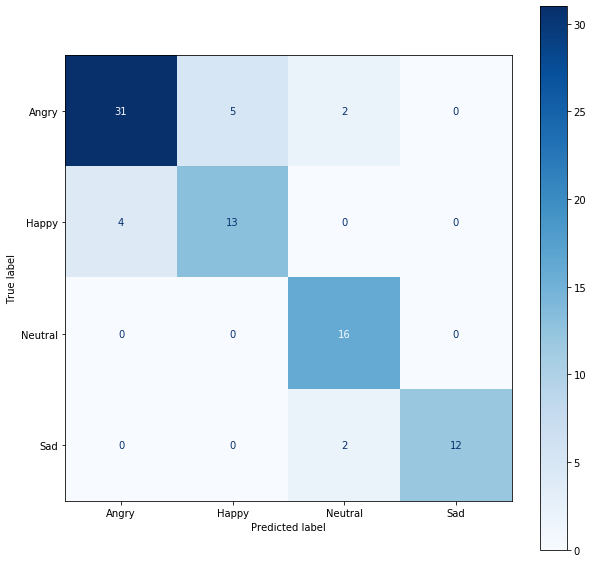

In [ ]:
import sklearn
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from google.colab import files

# Initialize the Multi Layer Perceptron Classifier
model=MLPClassifier(alpha=0.001, batch_size=32, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive',max_iter=1000)

# Train the model
model.fit(x_train,y_train)

# Predict for the test set
y_pred=model.predict(x_test)

# Calculate the Accuracy of our model
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)

# Print the Accuracy
print("Accuracy (MLP): {:.2f}%".format(accuracy*100))

# Print the Classification report
print('\nClassification Report')
report = sklearn.metrics.classification_report(y_test, y_pred)
print(report)  

# Plot the Confusion matrix
plt.rcParams['figure.figsize'] = (10, 10)
disp = plot_confusion_matrix(model, x_test, y_test, display_labels=observed_emotions_B, cmap=plt.cm.Blues)

# Save and Display the Confusion plot
plt.savefig("MLP-Berlin.png")
plt.show()

# II.(a) ML Models - Support Vector Machines (SVM)


Accuracy (SVM): 74.12%

Classification Report
              precision    recall  f1-score   support

       Angry       0.70      0.97      0.81        38
       Happy       1.00      0.06      0.11        17
     Neutral       0.73      1.00      0.84        16
         Sad       1.00      0.64      0.78        14

    accuracy                           0.74        85
   macro avg       0.86      0.67      0.64        85
weighted avg       0.81      0.74      0.67        85



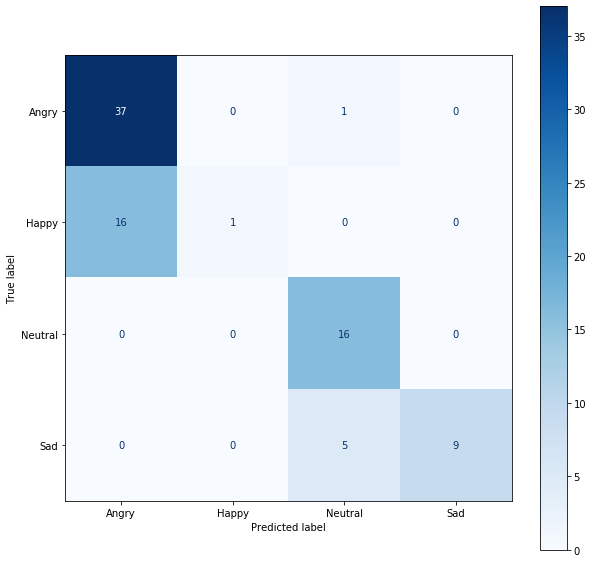

In [ ]:
from sklearn.svm import SVC

# Initializing SVM
model = SVC(kernel='rbf')
model.fit(x_train, y_train)

# Predicting for the test set
y_pred=model.predict(x_test)

# Calculate the Accuracy of our model
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)

# Print the Accuracy
print("Accuracy (SVM): {:.2f}%".format(accuracy*100))

# Print the Classification report
print('\nClassification Report')
report = sklearn.metrics.classification_report(y_test, y_pred)
print(report)  

# Plot the Confusion matrix
plt.rcParams['figure.figsize'] = (10, 10)
disp = plot_confusion_matrix(model, x_test, y_test, display_labels=observed_emotions_B, cmap=plt.cm.Blues)

# Save the Confusion plot
plt.savefig("SVM-Berlin.png")
plt.show()

# II.(b) ML Models - Random Forest Classifier


Accuracy (Random Forest): 72.94%

Classification Report
              precision    recall  f1-score   support

       Angry       0.74      0.84      0.79        38
       Happy       0.43      0.35      0.39        17
     Neutral       0.80      0.75      0.77        16
         Sad       0.92      0.86      0.89        14

    accuracy                           0.73        85
   macro avg       0.72      0.70      0.71        85
weighted avg       0.72      0.73      0.72        85



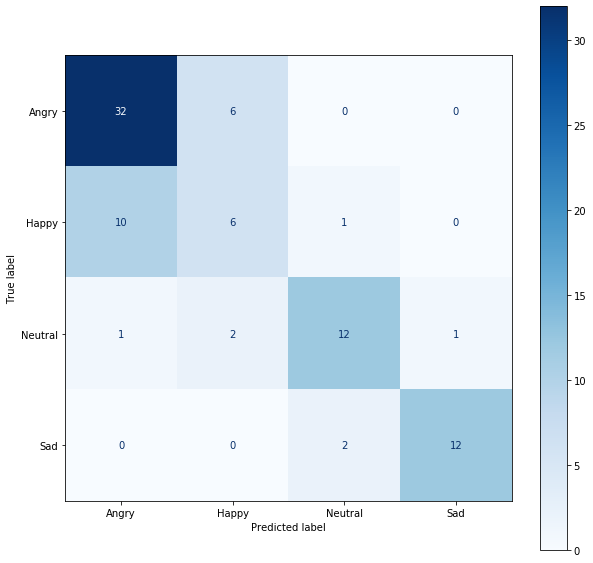

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialization
model = RandomForestClassifier(n_estimators=5)
model.fit(x_train, y_train)

# Predict for the test set
y_pred=model.predict(x_test)

# Calculate the Accuracy of our model
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)

# Print the Accuracy
print("Accuracy (Random Forest): {:.2f}%".format(accuracy*100))

# Print the Classification report
print('\nClassification Report')
report = sklearn.metrics.classification_report(y_test, y_pred)
print(report)  

# Plot the Confusion matrix
plt.rcParams['figure.figsize'] = (10, 10)
disp = plot_confusion_matrix(model, x_test, y_test, display_labels=observed_emotions_B, cmap=plt.cm.Blues)

# Save the Confusion plot
plt.savefig("RFC-Berlin.png")
plt.show()

# III. Convolutional Neural Network


85/85 [==============================] - 0s 125us/step
Accuracy (CNN): 89.41%

Classification Report
              precision    recall  f1-score   support

           1       0.92      0.92      0.92        38
           2       0.87      0.76      0.81        17
           3       0.84      1.00      0.91        16
           4       0.92      0.86      0.89        14

    accuracy                           0.89        85
   macro avg       0.89      0.89      0.88        85
weighted avg       0.90      0.89      0.89        85



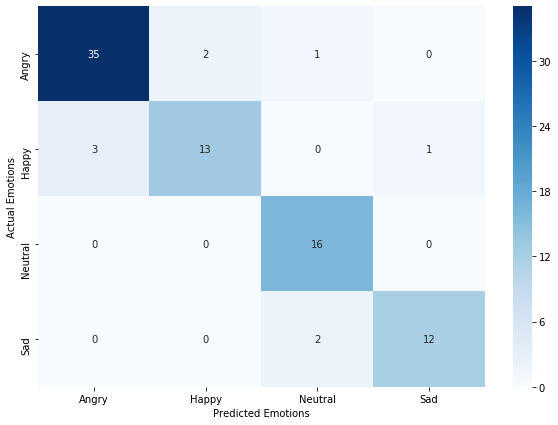

In [ ]:
import keras
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix


y_train_int = []
y_test_int = []
key_list = list(emotions_B.keys())
value_list = list(emotions_B.values())

for i in range(0,x_train.shape[0]):  
  temp = key_list[value_list.index(y_train[i])]
  y_train_int.append(temp)

for i in range(0,x_test.shape[0]):
  temp1 = key_list[value_list.index(y_test[i])]
  y_test_int.append(temp1)  

y_train_int = np.asarray(y_train_int)
y_test_int = np.asarray(y_test_int)
x_traincnn = np.expand_dims(x_train, axis=2)
x_testcnn = np.expand_dims(x_test, axis=2)

# Initialization the CNN model
model = Sequential()
model.add(Conv1D(256, 5,padding='same',input_shape=(x_traincnn.shape[1],1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(5))
model.add(Activation('softmax'))
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
model.compile(loss = 'sparse_categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
cnnhistory = model.fit(x_traincnn, y_train_int, batch_size=16, epochs=60, validation_data = (x_testcnn, y_test_int),verbose=0)
[cnnLoss, cnnAcc] = model.evaluate(x_testcnn, y_test_int, verbose=1)

# Print the Accuracy
print("Accuracy (CNN): {:.2f}%".format(cnnAcc*100))

# Predicting the Emotions from the Trained CNN
y_pred = model.predict(x_testcnn)

# Computing the Confusion matrix
y_test_int_temp = [int(val) for val in y_test_int]
C_matrix = confusion_matrix(y_test_int_temp, y_pred.argmax(axis=1))

# Print the Classification report
print('\nClassification Report')
report = sklearn.metrics.classification_report(y_test_int_temp, y_pred.argmax(axis=1))
print(report) 

# Plot the Confusion matrix
df_cm = pd.DataFrame(C_matrix, index = observed_emotions_B, columns = observed_emotions_B)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap="Blues")
plt.xlabel('Predicted Emotions')
plt.ylabel('Actual Emotions')

# Save the Confusion plot
plt.savefig("CNN-Berlin.png")
plt.show()